In [111]:
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sys
sys.setrecursionlimit(1000000)

In [112]:
id =[]
sequence = []
name_to_seq_dict = {}
from Bio import SeqIO
for seq_record in SeqIO.parse("9606.protein.sequences.v11.5.fa", "fasta"):
    id.append(seq_record.id)
    x = repr(seq_record.seq)[5:-2]
    l = ""
    for i in x:
        l = l + i + " "
    l = l.rstrip()
    
    sequence.append(l)
name_to_seq_dict = dict(zip(id, sequence))
name_to_seq_dict['9606.ENSP00000002829']
len(name_to_seq_dict) 

19566

In [113]:
data = pd.read_csv("ppi_dataset_from_positive_pair_string.csv")
data.head()
data['protein1_sequence'] = data.apply (lambda row: name_to_seq_dict[row['protein1']], axis=1)
data['protein2_sequence'] = data.apply (lambda row: name_to_seq_dict[row['protein2']], axis=1)

In [114]:
import torch
torch.cuda.is_available()

print('Device name:', torch.cuda.get_device_name(0))


Device name: NVIDIA GeForce RTX 2060


In [115]:
data_2 = pd.DataFrame()
data = data[['protein1_sequence','protein2_sequence','label']]
data['concat_protein'] = data['protein1_sequence'] +" " + data['protein2_sequence']
data_2['concat_protein'] = + data['protein2_sequence']+" " + data['protein1_sequence'] 
data_2['label'] = data['label']
data = data[['concat_protein','label']]
data_2 = data_2[['concat_protein','label']]

In [116]:
final_data = pd.concat([data,data_2]).reset_index(drop = True)

In [117]:
from sklearn.model_selection import train_test_split
X  = final_data.drop(['label'],axis=1).values
y = final_data['label'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [118]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('Rostlab/prot_bert_bfd', do_lower_case=False )

In [119]:
def preprocessing_for_bert(protein_sequences,MAX_LEN = 122):
    input_ids = []
    attention_masks = []
    for protein_sequence in tqdm(protein_sequences):
        id = tokenizer.batch_encode_plus(protein_sequence ,max_length = MAX_LEN, add_special_tokens=True, pad_to_max_length=True)
        input_id = id.get('input_ids')
        attention_mask = id.get('attention_mask')
        input_ids.append(input_id)
        attention_masks.append(attention_mask)
    
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)
    
    return input_ids, attention_masks

In [120]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
y_train = torch.tensor(y_train)
y_test = torch.tensor(y_test)
y_test = y_test[0:10000]

In [121]:
len(y_train)

169248

In [122]:
test_inputs,test_masks = preprocessing_for_bert(X_test[0:10000])

  0%|                                                                                        | 0/10000 [00:00<?, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
C:\Users\danwe\anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:2285: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for B

In [130]:
batch_size = 16
# train_data = TensorDataset(train_inputs, train_masks,y_train)
# train_sampler = RandomSampler(train_data)
# train_dataloader = DataLoader(train_data, sampler = train_sampler, batch_size = batch_size,drop_last=True)

test_data = TensorDataset(test_inputs, test_masks,y_test)
test_sampler = RandomSampler(test_data)
test_dataloader = DataLoader(test_data, sampler = test_sampler, batch_size = batch_size,drop_last=True)

In [124]:
import torch
import torch.nn as nn
from transformers import BertModel, BertTokenizer
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [125]:
device

device(type='cuda', index=0)

In [126]:
class BertClassifier(nn.Module):
    
    def __init__(self, embed_dim = 1024):
        super(BertClassifier,self).__init__()
        self.bert = BertModel.from_pretrained("Rostlab/prot_bert_bfd")
        
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(embed_dim,512)
        self.fc2 = nn.Linear(512,256)
        
        self.fc3 = nn.Linear(512,64)
        self.fc4 = nn.Linear(64,32)
        
        self.fc5 = nn.Linear(32,16)
        self.fc6 = nn.Linear(16,8)
        self.fc7 = nn.Linear(8,1)

    
    def forward(self, input_ids,attention_mask):
        
        embedding = self.bert(input_ids=input_ids,attention_mask=attention_mask)
        output = torch.tensor(embedding[0][:, 0, :])
        # print(output)
        output_1 = self.relu(self.fc1(output))
        output_2 = self.relu(self.fc3(output_1))
        output_3 = self.relu(self.fc4(output_2))
        output_4 = self.relu(self.fc5(output_3))
        output_5 = self.relu(self.fc6(output_4))
        output = self.fc7(output_5)

        return output

In [131]:
import torch.optim as optim

def initilize_model(learning_rate=0.001):
    """Instantiate a CNN model and an optimizer."""

    model = BertClassifier()
    
    
    # Send model to `device` (GPU/CPU)
    model.to(device)

    
    return model

In [132]:
model = initilize_model(learning_rate=0.01)
checkpoint = torch.load('best_mode_trained_after_37_epochs.pth')
model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

Some weights of the model checkpoint at Rostlab/prot_bert_bfd were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<All keys matched successfully>

In [133]:
model.eval()
loss_fn = nn.BCEWithLogitsLoss()    
val_accuracy = []
val_loss = []
y_test = []
y_pred  = []
for batch in tqdm(test_dataloader):
        # Load batch to GPU
    b_input_ids, b_attn_masks, b_labels = tuple(t.to(device) for t in batch)
    b_input_ids = b_input_ids.reshape((1,16,122)).squeeze(0)
    b_attn_masks = b_attn_masks.reshape((1,16,122)).squeeze(0)
    b_labels = b_labels.reshape((1,16,1)).squeeze(0)
    with torch.no_grad():
        logits = model( b_input_ids, b_attn_masks)
        
        
        
    
    loss = loss_fn(logits, b_labels.float())

    val_loss.append(loss.item())
# # model = BertModel.from_pretrained("Rostlab/prot_bert_bfd")
# for i in tqdm(train_dataloader):
#     print(i)
    preds = torch.round(torch.sigmoid(logits))
        # print(preds,b_labels)
    accuracy = (preds.float() == b_labels.float()).cpu().numpy().mean() * 100
    y_test.extend( b_labels.float())
    y_pred.extend(preds.float())
    val_accuracy.append(accuracy)
    
val_loss = np.mean(val_loss)
val_accuracy = np.mean(val_accuracy)
print(val_accuracy)

  0%|                                                                                          | 0/625 [00:00<?, ?it/s]C:\Users\danwe\AppData\Local\Temp/ipykernel_19200/3806280748.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output = torch.tensor(embedding[0][:, 0, :])
100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [03:57<00:00,  2.63it/s]

85.79


In [135]:
y_test = torch.tensor(y_test, device = 'cpu')
y_pred = torch.tensor(y_pred, device = 'cpu')


C:\Users\danwe\AppData\Local\Temp/ipykernel_19200/2547964273.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test, device = 'cpu')
C:\Users\danwe\AppData\Local\Temp/ipykernel_19200/2547964273.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred = torch.tensor(y_pred, device = 'cpu')


In [136]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score

## Model result

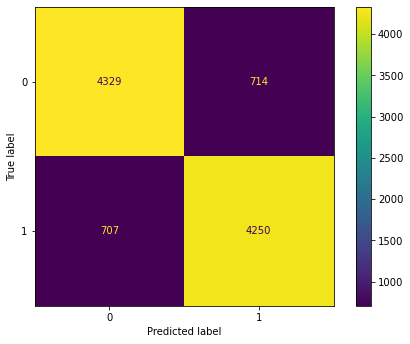

In [137]:
# y_test =  y_test.to('cpu')
# y_pred =  y_pred.to('cpu')
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8,5.5)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

## Model testing on APID dataset

In [96]:
test_apid = pd.read_csv("apid_test_set.csv")
test_apid = test_apid[['UniprotName_A_sequence','UniprotName_B_sequence','label']]
test_apid

,UniprotName_A_sequence,UniprotName_B_sequence,label
0,M S Q S K G K K R N P G L K I P K E A F E Q P ...,M E G S K T S N N S T M Q V S F V C Q R C S Q ...,1
1,M A D Q L T E E Q I A E F K E A F S L F D K D ...,M N F T V G F K P L L G D A H S M D N L E K Q ...,1
2,M F E E P E W A E A A P V A A G L G P V I S R ...,M A C A R P L I S V Y S E K G E S S G K N V T ...,1
3,M T R K N Y T S L T E F V L L G L A D T L E L ...,M A S V T R A V F G E L P S G G G T V E K F Q ...,1
4,M A A L D L R A E L D S L V L Q L L G D L E E ...,M S C I N L P T V L P G S P S K T R G Q I Q V ...,1
...,...,...,...
1995,M A A S R Y R R F L K L C E E W P V D E T K R ...,M A E E R E P E L Y L K W K H C E T P G V K T ...,0
1996,M N S G R E P R T P R T L L S I A D I L A P R ...,M A R V G P G R A G V S C Q G R G R G R G G S ...,0
1997,M G S L V L T L C A L F C L A A Y L V S G S P ...,M L S R A V C G T S R Q L A P V L G Y L G S R ...,0
1998,M T V R N I A S I C N M G T N A S A L E K D I ...,M A L D V K S R A K R Y E K L D F L G E G Q F ...,0


In [97]:
test_apid_2 = pd.DataFrame()
test_apid = test_apid[['UniprotName_A_sequence','UniprotName_B_sequence','label']]
test_apid['concat_protein'] = test_apid['UniprotName_A_sequence'] +" " + test_apid['UniprotName_B_sequence']
test_apid_2['concat_protein'] = + test_apid['UniprotName_B_sequence']+" " + test_apid['UniprotName_A_sequence'] 
test_apid_2['label'] = test_apid['label']
test_apid = test_apid[['concat_protein','label']]
test_apid_2 = test_apid_2[['concat_protein','label']]
final_data_apid = pd.concat([test_apid,test_apid_2]).reset_index(drop = True)

In [98]:
final_data_apid.label.value_counts()

1    2000
0    2000
Name: label, dtype: int64

In [99]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('Rostlab/prot_bert_bfd', do_lower_case=False )

In [100]:
def preprocessing_for_bert(protein_sequences,MAX_LEN = 1000):
    input_ids = []
    attention_masks = []
    for protein_sequence in tqdm(protein_sequences):
        id = tokenizer.batch_encode_plus(protein_sequence ,max_length = MAX_LEN, add_special_tokens=True, pad_to_max_length=True)
        input_id = id.get('input_ids')
        attention_mask = id.get('attention_mask')
        input_ids.append(input_id)
        attention_masks.append(attention_mask)
    
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)
    
    return input_ids, attention_masks

In [101]:
max_len  = max([len(i) for i in final_data_apid['concat_protein'].tolist()])
max_len

1983

In [102]:
X  = final_data_apid.drop(['label'],axis=1).values
y = final_data_apid['label'].values

In [103]:
y =torch.tensor(y)
X.shape

(4000, 1)

In [104]:
batch_size = 2
# train_data = TensorDataset(train_inputs, train_masks,y_train)
# train_sampler = RandomSampler(train_data)
# train_dataloader = DataLoader(train_data, sampler = train_sampler, batch_size = batch_size,drop_last=True)
test_inputs,test_masks = preprocessing_for_bert(X)
test_data = TensorDataset(test_inputs, test_masks,y)
test_sampler = RandomSampler(test_data)
test_dataloader = DataLoader(test_data, sampler = test_sampler, batch_size = batch_size,drop_last=True)

  0%|                                                                                         | 0/4000 [00:00<?, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
C:\Users\danwe\anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:2285: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for B

In [107]:
model.eval()
loss_fn = nn.BCEWithLogitsLoss()    
val_accuracy = []
val_loss = []
y_test = []
y_pred  = []
for batch in tqdm(test_dataloader):
        # Load batch to GPU
    b_input_ids, b_attn_masks, b_labels = tuple(t.to(device) for t in batch)
    b_input_ids = b_input_ids.reshape((1,2,1000)).squeeze(0)
    b_attn_masks = b_attn_masks.reshape((1,2,1000)).squeeze(0)
    b_labels = b_labels.reshape((1,2,1)).squeeze(0)
    with torch.no_grad():
        logits = model( b_input_ids, b_attn_masks)
        
        
        
    
    loss = loss_fn(logits, b_labels.float())

    val_loss.append(loss.item())
# # model = BertModel.from_pretrained("Rostlab/prot_bert_bfd")
# for i in tqdm(train_dataloader):
#     print(i)
    preds = torch.round(torch.sigmoid(logits))
        # print(preds,b_labels)
    accuracy = (preds.float() == b_labels.float()).cpu().numpy().mean() * 100
    y_test.extend( b_labels.float())
    y_pred.extend(preds.float())
    val_accuracy.append(accuracy)
    
val_loss = np.mean(val_loss)
val_accuracy = np.mean(val_accuracy)
print(val_accuracy)

  0%|                                                                                         | 0/2000 [00:00<?, ?it/s]C:\Users\danwe\AppData\Local\Temp/ipykernel_19200/3806280748.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output = torch.tensor(embedding[0][:, 0, :])
100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [22:12<00:00,  1.50it/s]

57.0


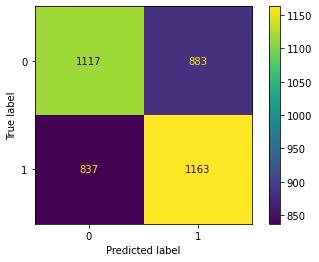

In [109]:
y_test = torch.tensor(y_test, device = 'cpu')
y_pred = torch.tensor(y_pred, device = 'cpu')
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()